In [32]:
%run ./_setup.ipynb

# Data Description

## Summary of conditions during storm

In [2]:
# dates corresponding to sea surface plots from TXLA model that we compare with for storm surge
ssh_dates = [pd.Timestamp('2017-8-25 20'), pd.Timestamp('2017-8-29 12'), pd.Timestamp('2017-8-31 00')]

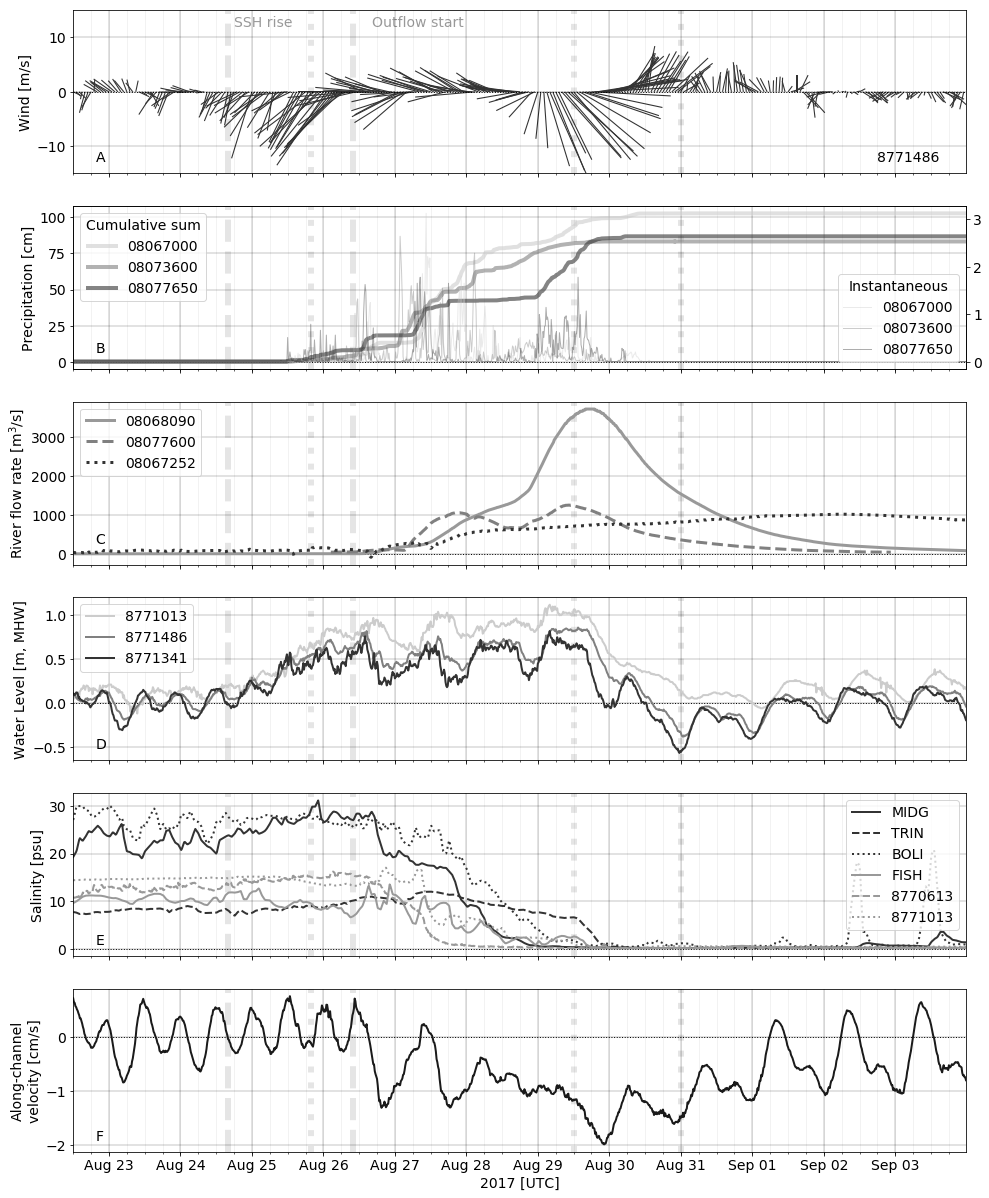

In [3]:
# define short dataframe to simplify plotting
dsp = '2017-08-22 12:00'; dep = '2017-09-3'
ddt = 1
dfsh = df.copy()[::ddt][dsp:dep]
dfsh['idx'] = date2num(pd.to_datetime(dfsh.index).to_pydatetime())
width = 0.2

fig, axes = plt.subplots(6, 1, figsize=(16,21), sharex=True)

    
## Wind ##
buoy = '8771486'
dw = 4
axes[0].quiver(dfsh['idx'][::dw], np.zeros(len(dfsh[::dw])), dfsh[buoy + ': East [m/s]'][::dw], dfsh[buoy + ': North [m/s]'][::dw], 
               headaxislength=0, headlength=0, width=width, units='y', scale_units='y', scale=1, 
               color='0.2', label=buoy)
axes[0].text(0.9, 0.075, buoy, fontsize=14, transform=axes[0].transAxes)
axes[0].text(0.025, 0.072, 'A', fontsize=14, transform=axes[0].transAxes)
   
    
## Precipitation ##
ax1 = axes[1].twinx()
bs = ['08067000', '08073600', '08077650']
for i, (buoy, col) in enumerate(zip(bs,['0.8', '0.5', '0.2'])):
    ax1.plot(dfsh.index, dfsh[buoy + ': Rain [cm]'], color=col, lw=1, alpha=0.4)  # instantaneous
    axes[1].plot(dfsh.index, dfsh[buoy + ': Rain [cm]'].cumsum(), color=col, lw=4, alpha=0.6)  # cumulative
axes[1].legend(bs, loc='upper left', title='Cumulative sum')
ax1.legend(bs, loc='lower right', title='Instantaneous')
axes[1].text(0.025, 0.1, 'B', fontsize=14, transform=axes[1].transAxes)


## River Gauges ##
bs = ['08068090', '08077600', '08067252']
for buoy, col, ls in zip(bs, ['0.6', '0.5', '0.2'],['-', '--',':']):
    axes[2].plot(dfsh.index, dfsh[buoy + ': Flow rate [m^3/s]'], color=col, lw=3, linestyle=ls)
axes[2].legend(bs, loc='upper left')
axes[2].text(0.025, 0.13, 'C', fontsize=14, transform=axes[2].transAxes)


## Sea Level ##
lws = [2,2,2]
for buoy, col, lw in zip(['8771013', '8771486', '8771341'], ['0.8', '0.5', '0.2'], lws):
    axes[3].plot(dfsh.index, dfsh[buoy + ': Water Level [m, MHW]'], label=buoy, color=col, lw=lw)
axes[3].legend()
axes[3].text(0.025, 0.072, 'D', fontsize=14, transform=axes[3].transAxes)
    
## Salinity ##
bs = ['MIDG', 'TRIN', 'BOLI', 'FISH', '8770613', '8771013']
linestyles = ['-', '--', ':', '-', '--', ':']
colors = ['0.2', '0.2', '0.2', '0.6', '0.6', '0.6']
for buoy, ls, col in zip(bs, linestyles, colors):
    axes[4].plot(dfsh.index, dfsh[buoy + ': Salinity'], label=buoy, color=col, lw=2, ls=ls)
axes[4].legend(loc='best')
axes[4].text(0.025, 0.072, 'E', fontsize=14, transform=axes[4].transAxes)


## Entrance along-channel velocity ##
axes[5].plot(dfsh.index, dfsh['smean'], color='0.1', lw=2)
axes[5].text(0.025, 0.072, 'F', fontsize=14, transform=axes[5].transAxes)


axes[0].set_ylim(-15,15)
axes[0].set_xlim(dfsh.index[0], dfsh.index[-1])
for ax in axes:
    ax.hlines(0, dfsh.index[0], dfsh.index[-1], linewidth=1, linestyle=':')
    ax.grid(which='major', lw=1.5, color='k', alpha=0.15)
    ax.grid(which='minor', lw=1, color='k', alpha=0.05)
    # overlay lines for events
    ylims = ax.get_ylim()
    ax.set_ylim(*ylims)
    ax.vlines(date_ssh, *ylims, linewidth=6, alpha=0.1, color='k', linestyle='--')
    ax.vlines(date_outflow, *ylims, linewidth=6, alpha=0.1, color='k', linestyle='--')
    for ssh_date in ssh_dates:
        ax.vlines(ssh_date, *ylims, linewidth=6, alpha=0.1, color='k', linestyle=':')

# labels
axes[0].set_ylabel('Wind [m/s]')
axes[1].set_ylabel('Precipitation [cm]')
axes[2].set_ylabel('River flow rate [m$^3$/s]')
axes[3].set_ylabel('Water Level [m, MHW]')
axes[4].set_ylabel('Salinity [psu]')
axes[5].set_ylabel('Along-channel\nvelocity [cm/s]')

# label dates
axes[0].text(0.18, 0.9, 'SSH rise', transform=axes[0].transAxes, alpha=0.4)
axes[0].text(0.335, 0.9, 'Outflow start', transform=axes[0].transAxes, alpha=0.4)


minor = mpl.dates.HourLocator(byhour=np.arange(0,24,6))
ax.xaxis.set_minor_locator(minor)
major = mpl.dates.HourLocator(byhour=np.arange(0,24,24))
ax.xaxis.set_major_locator(major)
ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%b %d'))

handles, labels = ax.get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))

ax.set_xlabel('2017 [UTC]');

plt.savefig('../figures/conditions.pdf', bbox_inches='tight')

## Rain distribution

### Set up drainage basin regions for plotting and calculating

First we have the large-scale drainage basin which we will compare with rainfall. We start by downloading the file.

In [4]:
!wget http://www.twdb.texas.gov/mapping/gisdata/doc/Major_River_Basins_Shapefile.zip
    
unpack_archive('Major_River_Basins_Shapefile.zip', '%s/Major_River_Basins_Shapefile/' % basesf)

--2019-05-06 09:36:54--  http://www.twdb.texas.gov/mapping/gisdata/doc/Major_River_Basins_Shapefile.zip
Resolving www.twdb.texas.gov... 3.212.105.119, 52.86.17.100
Connecting to www.twdb.texas.gov|3.212.105.119|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3960925 (3.8M) [application/x-zip-compressed]
Saving to: ‘Major_River_Basins_Shapefile.zip.5’

Major_River_Basins_ 100%[===================>]   3.78M  4.51MB/s    in 0.8s    

2019-05-06 09:36:55 (4.51 MB/s) - ‘Major_River_Basins_Shapefile.zip.5’ saved [3960925/3960925]



In [5]:
basinnamesgb = ['San Jacinto-Brazos', 'San Jacinto', 'Trinity-San Jacinto', 'Trinity']

# read in shapefile data and select the basins that we want
reader = cartopy.io.shapereader.Reader(basesf + 'Major_River_Basins_Shapefile/TWDB_MRBs_2014.shp')
basins = reader.records()
basinsgb = []
for basin in basins:
    if basin.attributes['basin_name'] in basinnamesgb:
        basinsgb.append(basin)

# combine into one basin. Need buffer because there are small gaps between shapes
gbfull = shapely.ops.unary_union([basingb.geometry.buffer(0.1) for basingb in basinsgb])

# convert gbfull from pc to aea
gbfullaea = aea.project_geometry(gbfull, pc)

Next we read in the river basins included in the inflow estimate from Texas Water Development Board:

In [6]:
# TWDB river basins
twdbshapes = 'galv_ws_nad83_prj_albers_equal_area_conic_USGS'
fname = '%s%s/%s.shp' % (basesf, twdbshapes, twdbshapes)
reader = cartopy.io.shapereader.Reader(fname)
basins = reader.records()
spgbs = []
spgbs_model = []
for basin in basins:
    if basin.attributes['WS_ID'] in idgb:
        # save all basins in the inflow estimate
        spgbs.append(basin)
        wstype = basin.attributes['WS_type'].split(' ')[0]
        # separately select out ungauged basins
        if wstype == 'Ungauged' or wstype == 'Ungaged': 
            spgbs_model.append(basin)

# outline of full region
spgbfull = shapely.ops.unary_union([spgb.geometry for spgb in spgbs])

# outline of modeled region
spgbfull_model = shapely.ops.unary_union([spgb.geometry for spgb in spgbs_model])

### Read and arrange rain data

Download and read in in gridded precipitation data:

In [7]:
# this will download the file to the present file location
!wget https://water.weather.gov/precip/downloads/2017/08/31/nws_precip_last7days_20170831_conus.nc
    
# move it to data directory
%mv nws_precip_last7days_20170831_conus.nc $baser

--2019-05-06 09:37:27--  https://water.weather.gov/precip/downloads/2017/08/31/nws_precip_last7days_20170831_conus.nc
Resolving water.weather.gov... 104.73.167.46
Connecting to water.weather.gov|104.73.167.46|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5538806 (5.3M) [application/x-netcdf]
Saving to: ‘nws_precip_last7days_20170831_conus.nc’

nws_precip_last7day 100%[===================>]   5.28M  9.09MB/s    in 0.6s    

2019-05-06 09:37:28 (9.09 MB/s) - ‘nws_precip_last7days_20170831_conus.nc’ saved [5538806/5538806]



In [8]:
# Read in rain data
ds = xr.open_dataset('%s/nws_precip_last7days_20170831_conus.nc' % baser)

# Set up x and y locations
X, Y = np.meshgrid(ds['x'].values, ds['y'].values)

# convert x and y locations to aea projection
rainaea = aea.transform_points(stereo, X, Y)
xrainaea = rainaea[:,:,0]; yrainaea = rainaea[:,:,1]
# combine together
xrainaea2 = np.hstack(((xrainaea[:,0]-abs(xrainaea[:,0]-xrainaea[:,1]))[:,np.newaxis],xrainaea))
yrainaea2 = np.vstack(((yrainaea[0,:]+abs(yrainaea[0,:]-yrainaea[1,:]))[np.newaxis,:],yrainaea))

# calculate rain grid cell area
da = abs(xrainaea2[:,1:] - xrainaea2[:,:-1]) * abs(yrainaea2[1:,:] - yrainaea2[:-1,:])

# create Shapely Shapes out of rain grid cells
# need to convert from inches to cm of rain
# ds['x'], ds['y'], ds['observation']*2.54
rainpts = []
for x, y, z, a in zip(xrainaea.flatten(), yrainaea.flatten(), ds['observation'].values.flatten(), da.flatten()):
    # 3rd coord is rain in m^3
    rainpts.append(shapely.geometry.Point(x,y,z*2.54/100*a))

### Find how much of the rain is in large drainage basin

In [9]:
# find what rain pts the overall gb shape contains
rainptsbasingb = []
rainbasingb = 0
for rainpt in rainpts:
    if gbfullaea.contains(rainpt):
        rainptsbasingb.append(rainpt)
        x, y, r = zip(*rainpt.coords)
        rainbasingb += r[0]
        
print(rainbasingb/1000**3)  # in km^3

22.6462983099498


### Read in hurricane track data

From HURDAT2.

In [10]:
# read in hurricane track data — hurdat2
cols = ['yeardate', 'hour', 'class', 'lat', 'lon', 'wind [kts]']
# narrow in on harvey rows only
dd = pd.read_csv('https://www.nhc.noaa.gov/data/hurdat/hurdat2-1851-2017-050118.txt', skiprows=51661, header=None,
                 usecols=[0,1,3,4,5,6], names=cols, parse_dates=[[0,1]], nrows=74)
dd.index = [pd.Timestamp(dd['yeardate_hour'][i]) for i in range(len(dd))]
dd['lat'] = [float(dd['lat'][i][1:-1]) for i in range(len(dd))]
dd['lon'] = [-float(dd['lon'][i][1:-1]) for i in range(len(dd))]
dd['wind [m/s]'] = dd['wind [kts]']/1.944

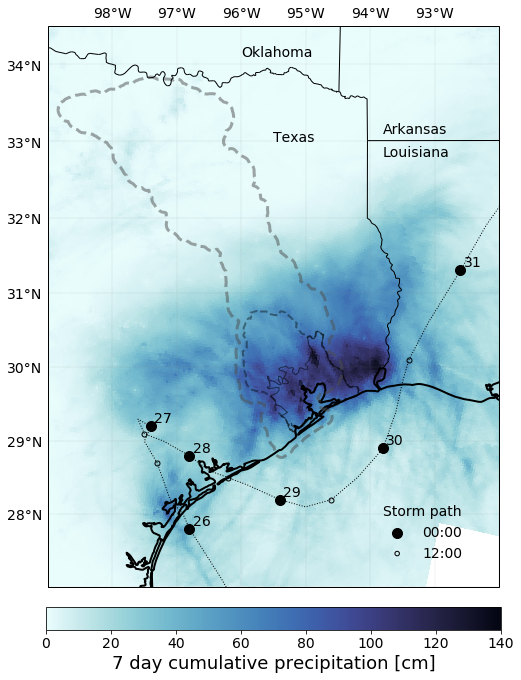

In [11]:
extent = [-99.0, -92, 27.0, 34.5]
x1, x2, y1, y2 = extent
pts = np.array([[x1, y1], [x1, y2], [x2, y2], [x2, y1]])
ext = shapely.geometry.Polygon(pts)


fig = plt.figure(figsize=(10, 10))
ax = fig.add_axes([0.06, 0.01, 0.93, 0.95], projection=merc)
ax.set_frame_on(False)
ax.set_extent(extent, pc)
gl = ax.gridlines(linewidth=0.2, color='gray', alpha=0.5, linestyle='-', draw_labels=True)
# the following two make the labels look like lat/lon format
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlocator = mpl.ticker.FixedLocator(np.arange(extent[0]-1, extent[1]+1, 1))
gl.ylocator = mpl.ticker.FixedLocator(np.arange(extent[2]-1, extent[3]+1, 1))
gl.xlabels_bottom = False  # turn off labels where you don't want them
gl.ylabels_right = False

ax.add_feature(coast_10m, zorder=10, linewidth=2)
ax.add_feature(states_provinces, edgecolor='k', zorder=13, linewidth=1)

mappable = ax.pcolormesh(ds['x'], ds['y'], ds['observation']*2.54, vmin=0, vmax=140, transform=stereo, cmap=cmo.ice_r)

cb = fig.colorbar(mappable, orientation='horizontal', pad=0.03, shrink=0.68)
cb.set_label('7 day cumulative precipitation [cm]', fontsize=18)

ax.add_geometries([gbfullaea], aea, facecolor='none', edgecolor='0.3', alpha=0.5, zorder=12, linewidth=3, linestyle='--')

# outline full watershed region
ax.add_geometries([spgbfull], aea, facecolor='none', edgecolor='k', alpha=0.4, linewidth=2, linestyle='--')

# outline modeled watershed region
ax.add_geometries([spgbfull_model], aea, facecolor='none', edgecolor='k', alpha=0.55, linewidth=1, linestyle='-')

# plot storm path
rows = pd.date_range('2017-8-26 12:00','2017-8-31 12:00', freq='24h')
ax.plot(dd['lon'][rows], dd['lat'][rows], 'o', ms=5, transform=pc, mfc='none', mec='k')
rows = pd.date_range('2017-8-26','2017-8-31', freq='24h')
ax.plot(dd['lon'][rows], dd['lat'][rows], 'ko', ms=10, transform=pc)
ax.plot(dd['lon'], dd['lat'], 'k:', lw=1, transform=pc)

# label days
for row in rows:
    ax.text(dd['lon'][row]+0.05, dd['lat'][row]+0.05, row.day, transform=pc)

# Add legend
ax2 = fig.add_axes([0.675, 0.2, 0.13, 0.3], frameon=False)
ax2.scatter([], [], c='k', s=100, marker='o', label='00:00')
ax2.scatter([], [], s=20, marker='o', c='none', edgecolors='k', label='12:00')
ax2.legend(scatterpoints=1, frameon=False, title='Storm path', loc='lower right')
ax2.set_axis_off()

# labels
ax.text(-95.5, 33, 'Texas', transform=pc)
ax.text(-93.8, 32.8, 'Louisiana', transform=pc)
ax.text(-93.8, 33.1, 'Arkansas', transform=pc)
ax.text(-96, 34.1, 'Oklahoma', transform=pc)

fig.savefig('../figures/maprain.png', bbox_inches='tight', dpi=300)
fig.savefig('../figures/maprain_lowres.png', bbox_inches='tight')

## Flooding Timescales

In [12]:
# pre-saved start and stop times
times = {'FISH': {'start': '2017-8-26 22:30', 'stop': '2017-8-30 12:00'},
        'MIDG': {'start': '2017-8-26 16:30', 'stop': '2017-8-29 00:00'},
        'TRIN': {'start': '2017-8-27 12:00', 'stop': '2017-8-31 00:00'},
        'BOLI': {'start': '2017-8-27 12:00', 'stop': '2017-8-30 00:00'},
        '8770613': {'start': '2017-8-26 15:30', 'stop': '2017-8-29 00:00'},
        '8771013': {'start': '2017-8-27 09:00', 'stop': '2017-8-29 20:00'}}

saltcols = [col for col in df.columns if 'Salinity' in col]
saltcols = [col for col in saltcols if not 'OLDR' in col]
saltcols = [col for col in saltcols if not 'B:' in col]
saltcols

# get some datetime numbers to use in calculation
df['idx'] = date2num(df.index.to_pydatetime())

In [13]:
# calculate lag times, which only depend on start time I chose vs. outflow start time
# Start time scale dictionary, tau
tau = dict()

for key in times.keys():
    tau[key] = dict()
    tau[key]['lag'] = (pd.Timestamp(times[key]['start']) - date_outflow).total_seconds()/86400

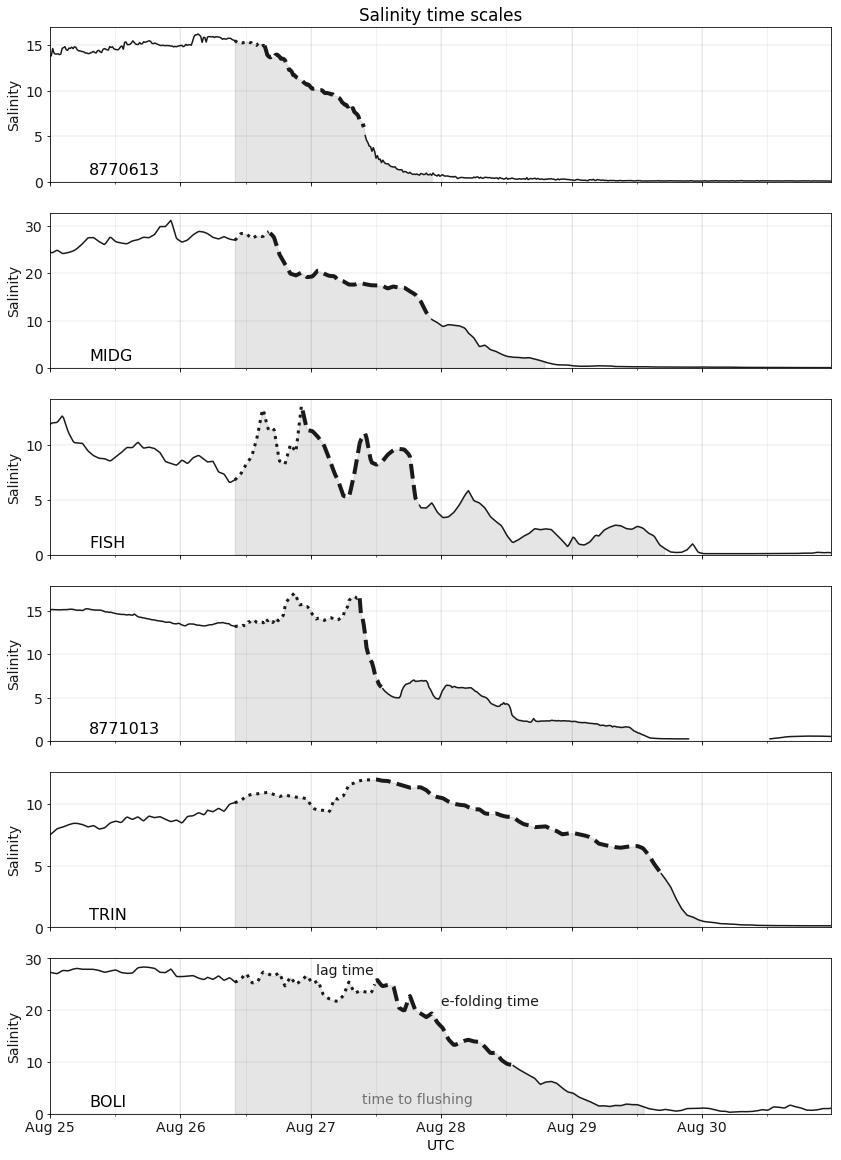

In [14]:
cols = ['8770613: Salinity', 'MIDG: Salinity', 'FISH: Salinity', '8771013: Salinity', 'TRIN: Salinity', 'BOLI: Salinity']

colorlag = '0.1'
colorefold = '0.1'
lslag = ':'
lsefold = '--'

dst = '2017-8-25'; den = '2017-8-30'
fig, axes = plt.subplots(len(saltcols), 1, figsize=(14,20), sharex=True)

taus = np.empty(len(saltcols))
for j, (col, ax) in enumerate(zip(cols, axes)):

    # get fit in linear space
    name = col.split(':')[0]

    start = times[name]['start']
    stop = times[name]['stop']

    tnums = df['idx'][start:stop] - df['idx'][start]  # decimal days
    dfshort = df[col][start:stop]
    
    S0 = df[col][start]  # initial salinity before freshwater inflow
    time_e = dfshort.index[np.where(dfshort<=S0*np.exp(-1))[0][0]]  # time at 37%*S0 salinity, datetime when efolding time happens
    tau[name]['efold'] = (time_e - pd.Timestamp(start)).total_seconds()/86400  # save e folding tau, in units of days

    time_overall = dfshort.index[np.where(dfshort<=S0*np.exp(-3))[0][0]]
    tau[name]['timeoverall'] = tau[name]['lag'] + (time_overall - pd.Timestamp(start)).total_seconds()/86400  # save lag + flooding time to 12% S0, in days

    # plot
    color = '0.1'
    # plot before flood
    ax.plot(df[dst:date_outflow].index, df[col][dst:date_outflow], color=color)  # plot data

    ax.tick_params(labelcolor=color)
    ax.set_ylabel('Salinity', color=color)
    # overlay lag time
    tstrlag = date_outflow + pd.Timedelta(str(tau[name]['lag']) + 'days')
    ax.plot(df[date_outflow:tstrlag].index, df[col][date_outflow:tstrlag], color=colorlag, lw=3, ls=lslag)  # plot data
    # overlay efolding time
    tstrefold = pd.Timestamp(start) + pd.Timedelta(str(tau[name]['efold']) + 'days')
    ax.plot(df[start:tstrefold].index, df[col][start:tstrefold], color=colorefold, lw=4, ls=lsefold)  # plot data
   
    tstrover = date_outflow + pd.Timedelta(str(tau[name]['timeoverall']) + 'days')
    ax.fill_between(df[date_outflow:tstrover].index, 0, df[col][date_outflow:tstrover], color='k', alpha=0.1)

    # plot after flood
    ax.plot(df[tstrefold:den].index, df[col][tstrefold:den], color=color)  # plot data
    
    # write station name and tau
    ax.text(0.05, 0.25 - 2*0.1, name, transform=ax.transAxes, fontsize=16)
    
    hours = mpl.dates.HourLocator(byhour=np.arange(0,24,12))
    ax.xaxis.set_minor_locator(hours)
    days = mpl.dates.HourLocator(byhour=np.arange(0,24,24))
    ax.xaxis.set_major_locator(days)

    ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%b %d'))
    ax.grid(which='major', lw=1.5, color='k', alpha=0.05)
    ax.grid(which='minor', lw=1, color='k', alpha=0.05)
    
    # label outflow start
    ylims = ax.get_ylim()
    ax.set_ylim(0, ylims[1])
    if j == len(saltcols)-1:  # first subplot, leaving space for line labels
        ylims = 0, 30
        ax.set_ylim(*ylims)
        # label lines
        ax.text(0.34, 0.9, 'lag time', transform=ax.transAxes, color=colorlag)
        ax.text(0.5, 0.7, 'e-folding time', transform=ax.transAxes, color=colorefold)
        ax.text(0.4, 0.07, 'time to flushing', transform=ax.transAxes, color='k', alpha=0.5)

axes[0].set_title('Salinity time scales')
axes[-1].set_xlabel('UTC')
axes[-1].autoscale(enable=True, axis='x', tight=True)

fig.savefig('../figures/times_flushing.pdf', bbox_inches='tight')

In [15]:
# Print times for table and map
for key in tau.keys():
    print(key)
    for tauname in tau[key].keys():
        print('%s %2.2f' % (tauname, tau[key][tauname]))

FISH
lag 0.52
efold 0.89
timeoverall 3.29
MIDG
lag 0.27
efold 1.24
timeoverall 2.38
TRIN
lag 1.08
efold 2.19
timeoverall 3.56
BOLI
lag 1.08
efold 1.04
timeoverall 3.15
8770613
lag 0.23
efold 0.77
timeoverall 1.51
8771013
lag 0.96
efold 0.18
timeoverall 3.11


### Present flushing timescales on maps

In [16]:
# to make map clearer
shift = {'TRIN': (0.01,0.01), 'FISH': (0.01,0.01), '8770613': (-0.03,0.02), 'MIDG': (0.01,0.01),
      '8771013': (-0.06,0.0), 'BOLI': (0.0,0.02)}

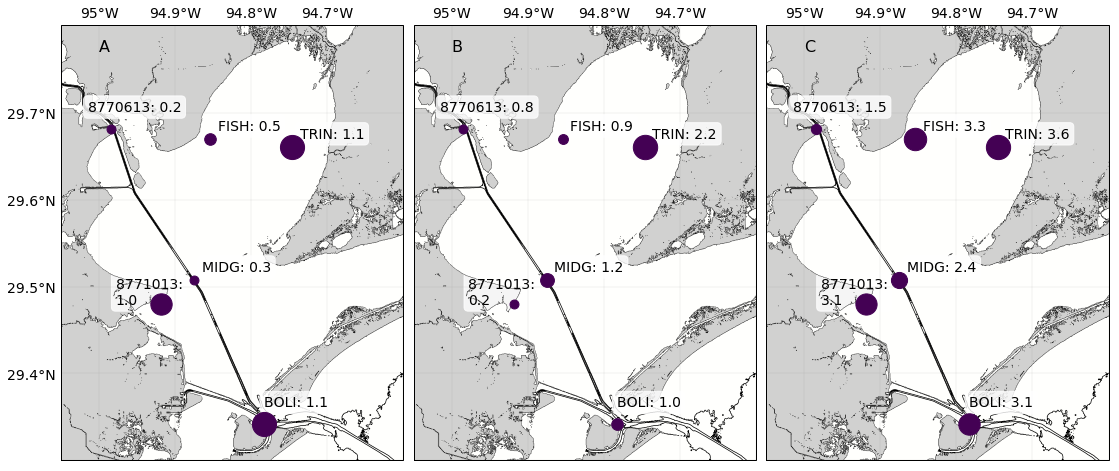

In [34]:
marker = 'o'
zorder = 10

types = ['lag', 'efold', 'timeoverall']
typenames = ['Freshwater pulse lag time', 'e-folding time', 'Time to 95% flushed']
letters = ['A','B','C']

fig = plt.figure(figsize=(15, 8))
fig.subplots_adjust(wspace=0.03, left=0.01, right=0.98)

for i, (which, whichname, letter) in enumerate(zip(types, typenames, letters)):
    ax = fig.add_subplot(1,3,i+1, projection=merc)
    ax.set_extent([-95.05, -94.6, 29.3, 29.8], pc)
    gl = ax.gridlines(linewidth=0.2, color='gray', alpha=0.5, linestyle='-', draw_labels=True)
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlocator = mpl.ticker.FixedLocator(np.arange(-96.2, -93.0, 0.1))
    gl.ylocator = mpl.ticker.FixedLocator(np.arange(28.6, 31, 0.1))
    gl.xlabels_bottom = False  # turn off labels where you don't want them
    gl.ylabels_right = False
    if i in [1,2]:
        gl.ylabels_left = False
        
    # subplot letter
    ax.text(-95, 29.77, letter, transform=pc, fontsize=16)

    # bathymetry contours
    ax.contour(bathy['lon'], bathy['lat'], bathy['all'], [-20,-15,-10], colors='k', linewidths=0.7, transform=pc, linestyles='-')  # some values

    # add bay-area detailed coastline
    ax.contour(bathy['lon'], bathy['lat'], bathy['mask'], 1, colors='0.1', linewidths=0.4, transform=pc)  # coastline

    # color land
    ax.pcolormesh(bathy['lon'], bathy['lat'], bathy['mask'], cmap=cmo.gray_r, vmin=0, vmax=7, transform=pc)

    # range of data
    data = np.asarray([tau[key][which] for key in tau.keys()])
    vmin = np.round(data.min(), decimals=1); vmax = np.round(data.max(), decimals=1)

    # size constant for each plot is different
    size0 = 600/vmax**2
    
    for i, saltcol in enumerate(saltcols):
        buoy = saltcol.split(':')[0]
        sdx, sdy = shift[buoy]

        # plot data
        lonsta, latsta = buoys[buoy]['ll']
        param = tau[buoy][which]
    
        s = param**2*size0
        
        # keep a minimum marker size so not too tiny
        if s < 80:
            s = 80

        ax.scatter(lonsta, latsta, c='0.2', s=s, transform=pc, zorder=10, marker=marker)
        
        if buoy == '8771013':
            label = '%s:\n%1.1f' % (buoy, param)
            zorder = 1
        else:
            label = '%s: %1.1f' % (buoy, param)
            zorder = 2
        ax.text(lonsta+sdx, latsta+sdy, label, transform=pc, bbox=props, zorder=zorder)    
        
fig.savefig('../figures/timescales_flushing_low.png', bbox_inches='tight')
fig.savefig('../figures/timescales_flushing.png', bbox_inches='tight', dpi=300)